In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
from GFire_utils.AllFunctions import *

pd.set_option('display.max_columns', None)

In [2]:
# Hyperparameters
x_coord = 'x'
y_coord = 'y'
z_coord = 'z'
lidar_columns = [x_coord, y_coord, z_coord, 'class']
heights_columns = [x_coord, y_coord, z_coord]

height_inc = 2 
height_centered = True 

In [3]:
# LiDAR and groundtruth reading
my_block = pd.read_csv('../nonzerogt_dataset/input_nonzerogt.txt', sep=' ', header = None, names = lidar_columns)

# Heights reading
metadata = pd.read_csv('../nonzerogt_dataset/met2v10as0f298107mr1r010.txt', sep=' ', skipinitialspace=True, header = None,
                       skip_blank_lines=True, nrows=6)
NCOLS, NROWS, XCENT, YCENT, CELLSIZE, NODATA_VALUE = map(int, metadata.iloc[:][1])

heights = pd.read_csv('../nonzerogt_dataset/met2v10as0f298107mr1r010.txt', sep=' ', header = None,
                      skip_blank_lines=True, skiprows=6)

In [4]:
# Fixing formats
heights = fix_format(heights, NCOLS)
heights = index_matrix(heights, XCENT, YCENT, CELLSIZE)
heights.columns = heights_columns

if height_centered: # Situating Coordenates to the bottom left corner of the square
    heights[x_coord] -= height_inc/2
    heights[y_coord] -= height_inc/2

r2 Accuracy:  0.9778801758652331


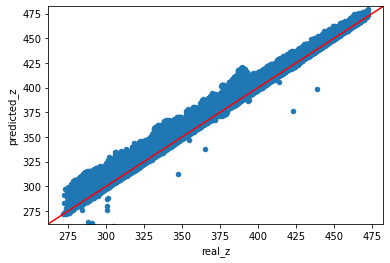

In [5]:
# Check how good our method predicts a block's height

# Grouping pixels by 2x2m points
my_block[x_coord] = ( my_block[x_coord]// height_inc )*height_inc
my_block[y_coord] = ( my_block[y_coord]// height_inc )*height_inc

if my_block[x_coord][0] % height_inc != heights[x_coord][0] % height_inc: # Blocks don't match, ones are even and others are odd
    my_block[x_coord] += height_inc/2 * (2*(my_block[x_coord] % 2 == 1)-1)
    my_block[y_coord] += height_inc/2 * (2*(my_block[y_coord] % 2 == 1)-1)

heights = heights.rename({z_coord:'real_z'}, axis=1)
my_block = my_block.rename({z_coord:'predicted_z'}, axis=1)
my_block = my_block.groupby([x_coord, y_coord])[['predicted_z']].min().reset_index()
heights = heights.groupby([x_coord, y_coord])[['real_z']].min().reset_index()

my_block = pd.merge(my_block, heights, on=[x_coord, y_coord], how='left')

if my_block[['real_z','predicted_z']].isnull().sum().sum() != 0:
    print("Merging was not made correctly")

acc = r2_score(my_block['real_z'], my_block['predicted_z'])

print("r2 Accuracy: ", acc)

my_block.plot.scatter(x='real_z', y = 'predicted_z')
plt.xlim(my_block['real_z'].min()-10, my_block['real_z'].max()+10)
plt.ylim(my_block['real_z'].min()-10, my_block['real_z'].max()+10)
plt.plot([my_block['real_z'].min()-10,my_block['real_z'].max()+10], 
         [my_block['real_z'].min()-10, my_block['real_z'].max()+10], c='red')
plt.show()